### Prediction of the temperature in London
Time series approach to longitidinal data <br>
Update: NB

Dataset: `london_weather.csv` containsing the following features:
- **date** - recorded date of measurement - (**int**)
- **cloud_cover** - cloud cover measurement in oktas - (**float**)
- **sunshine** - sunshine measurement in hours (hrs) - (**float**)
- **global_radiation** - irradiance measurement in Watt per square meter (W/m2) - (**float**)
- **max_temp** - maximum temperature recorded in degrees Celsius (°C) - (**float**)
- **mean_temp** - **target** mean temperature in degrees Celsius (°C) - (**float**)
- **min_temp** - minimum temperature recorded in degrees Celsius (°C) - (**float**)
- **precipitation** - precipitation measurement in millimeters (mm) - (**float**)
- **pressure** - pressure measurement in Pascals (Pa) - (**float**)
- **snow_depth** - snow depth measurement in centimeters (cm) - (**float**)

#### Preperation:
* load libraries
* set MLflow 
* read in data

In [117]:
#loading necessary libraries
import pandas as pd
import os
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from kaggle.api.kaggle_api_extended import KaggleApi

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [118]:
# Set MLflow tracking URI (make sure the directory exists or it will be created)
if not os.path.exists('mlruns'):
    os.makedirs('mlruns')

mlflow.set_tracking_uri("file:///C:/Users/nadja/PyProjects/LondonWeather/mlruns")

In [119]:
# Read in the data
from kaggle.api.kaggle_api_extended import KaggleApi

# Authenticate Kaggle API
api = KaggleApi()
api.authenticate()

# Download the dataset from Kaggle
api.dataset_download_files("abdelazizsami/predicting-temperature-in-london", path=".", unzip=True)

# Load the dataset into a pandas DataFrame
weather = pd.read_csv("london_weather.csv")




Dataset URL: https://www.kaggle.com/datasets/abdelazizsami/predicting-temperature-in-london


### Exploratory Data Analysis
* Explore dataset & data types
* fix index, missing values
* Visuals (target feature, decomposition, anual mean fluctuations)
* ACF/PACF-plots


In [120]:
# Perform exploratory data analysis 
print(weather.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB
None


In [121]:
# set date to daytime and make index
weather['date'] = pd.to_datetime(weather['date'], format='%Y%m%d')
weather.set_index('date', inplace=True)

In [122]:
# inspect ranges
weather.describe()
# scaling necessary

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
count,15322.000000,15341.000000,15322.000000,15335.000000,15305.000000,15339.000000,15335.000000,15337.000000,13900.000000
mean,5.268242,4.350238,118.756951,15.388777,11.475511,7.559867,1.668634,101536.605594,0.037986
std,2.070072,4.028339,88.898272,6.554754,5.729709,5.326756,3.738540,1049.722604,0.545633
min,0.000000,0.000000,8.000000,-6.200000,-7.600000,-11.800000,0.000000,95960.000000,0.000000
25%,4.000000,0.500000,41.000000,10.500000,7.000000,3.500000,0.000000,100920.000000,0.000000
50%,6.000000,3.500000,95.000000,15.000000,11.400000,7.800000,0.000000,101620.000000,0.000000
75%,7.000000,7.200000,186.000000,20.300000,16.000000,11.800000,1.600000,102240.000000,0.000000
max,9.000000,16.000000,402.000000,37.900000,29.000000,22.300000,61.800000,104820.000000,22.000000


In [123]:
#missing values
missing_values = weather.isnull().sum()
print(missing_values)

cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64


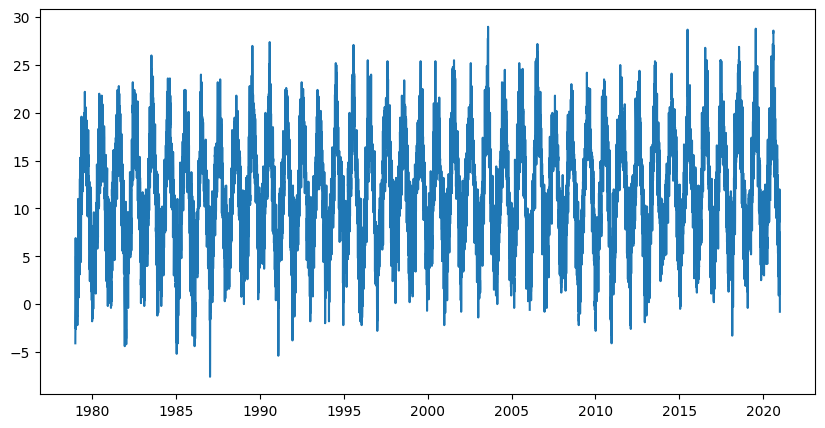

In [124]:
# Visuals of target feature
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(weather.index, weather['mean_temp'])
plt.show()

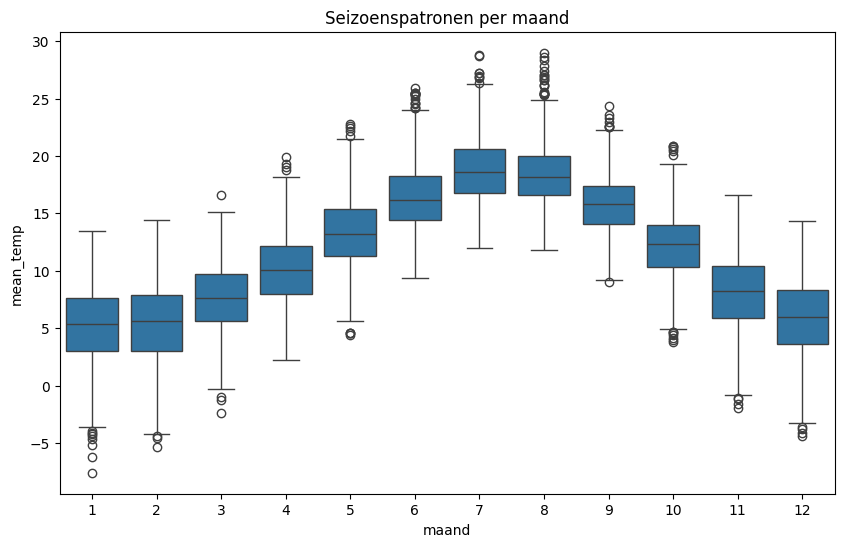

In [125]:
# Boxplot per maand
weather['maand'] = weather.index.month
plt.figure(figsize=(10,6))
sns.boxplot(x='maand', y='mean_temp', data=weather)
plt.title('Seizoenspatronen per maand')
plt.show()

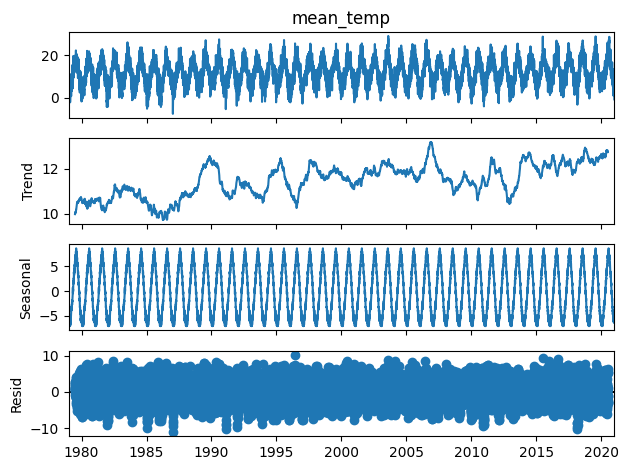

In [126]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Handle missing values by interpolation
mean_temp_interpolated = weather['mean_temp'].interpolate(method='linear')

# STL-seizoensdecompositie (werkt goed voor complexe seizoenspatronen)
result = seasonal_decompose(mean_temp_interpolated, model='additive', period=365)

# Plot de componenten
result.plot()
plt.show()

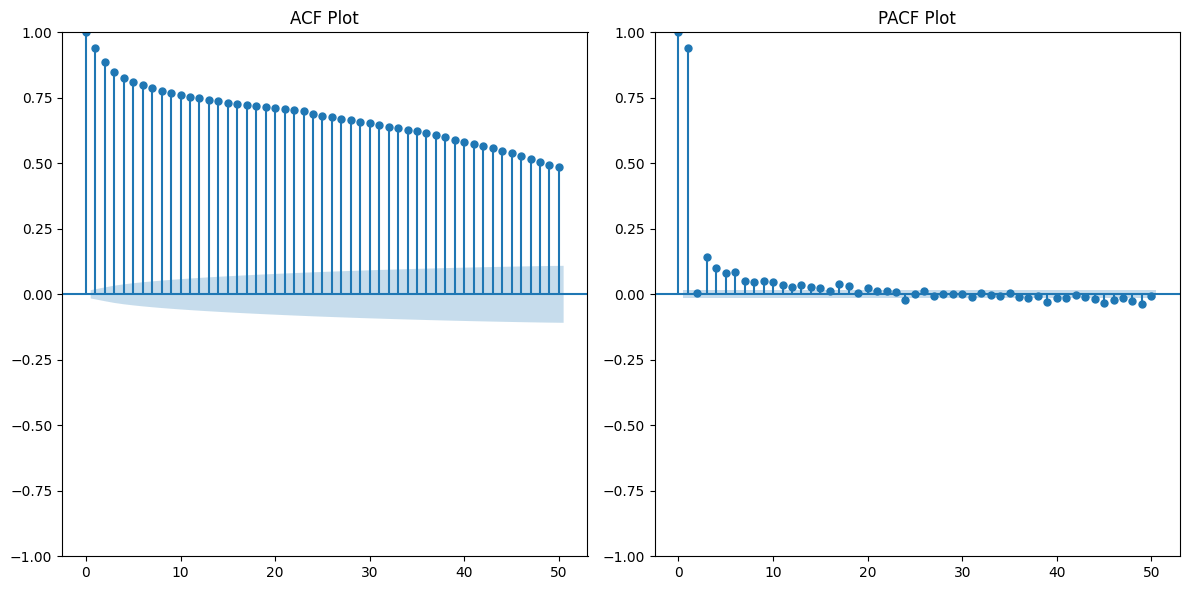

In [127]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#remove missing values temporarily, because acf& pacf can't handle
temp = weather['mean_temp'].interpolate(method='linear')

# plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot_acf(temp, lags=50, ax=axes[0])
axes[0].set_title("ACF Plot")

plot_pacf(temp, lags=50, ax=axes[1])
axes[1].set_title("PACF Plot")

plt.tight_layout()
plt.show()

In [128]:
# Test stationarity (Augmented Dickey-Fuller (ADF) test: H0: non-stationaire is rejected if p<0.05)
result = adfuller(weather['mean_temp'].dropna())

print("ADF Test Statistiek:", result[0])
print("p-waarde:", result[1])



ADF Test Statistiek: -8.569606461329128
p-waarde: 8.265991903890923e-14


### Modeling Time Series
* preprocessing: interpolation of missing values, lagging data, cleaning df

In [129]:
# Function to preprocess data
def preprocess_data(data):
    # Set the frequency of the date index to daily ('D')
    data.index = pd.to_datetime(data.index).to_period('D')
    # Handle missing values:interpolate linear
    target = ['mean_temp']
    features = ['cloud_cover', 'sunshine', 'precipitation', 'global_radiation', 'pressure', 'snow_depth']
    data[target] = data[target].interpolate(method='linear')
    data[features] = data[features].interpolate(method='linear')

    # Create lagged features (day before & last year same time)
    lags = [1,2]
    for lag in lags:
        data[f'mean_temp_lag{lag}'] = data[target].shift(lag)

    # Drop NaN rows created by lagging
    data = data.dropna()
    return data



In [130]:
def train_baseline(train, test):
    # Target variabele
    y_train_baseline = train['mean_temp']
    y_test_baseline = test['mean_temp']
    
    # Bepaal het gemiddelde van de trainingsset als baseline voorspelling
    mean_temp_train = y_train_baseline.mean()
    
    # Maak de voorspellingen (alle voorspellingen zijn het gemiddelde van de trainingsdata)
    y_pred_baseline = [mean_temp_train] * len(y_test_baseline)

    # Bereken de RMSE
    rmse_baseline = mean_squared_error(y_test_baseline, y_pred_baseline)
    mlflow.end_run()

    with mlflow.start_run(run_name="Baseline_Model"):
        mlflow.log_metric("Baseline RMSE", rmse_baseline)
        mlflow.log_param("model", "baseline")  # Log any additional parameters if needed
    return mean_temp_train, rmse_baseline

In [ ]:
# Function to train ARIMA model
def train_arima(train, test):
    X_train_arima = train[['mean_temp_lag1']]
    X_test_arima = test[['mean_temp_lag1']]
    y_train_arima = train['mean_temp']
    y_test_arima = test['mean_temp']

    with mlflow.start_run(run_name="ARIMA_Model"):
        # Fit the ARIMA model
        arima_model = ARIMA(y_train_arima, exog=X_train_arima, order=(1, 1, 1))
        arima_model_fit = arima_model.fit()

        # Make predictions
        y_pred_arima = arima_model_fit.predict(start=len(y_train_arima), 
                                               end=len(y_train_arima) + len(y_test_arima) - 1, 
                                               exog=X_test_arima)
        
        # Calculate RMSE
        rmse_arima = mean_squared_error(y_test_arima, y_pred_arima)
        
        #input ex
        input_example = X_train_arima.iloc[:1]  # A sample input
        #log model
        mlflow.log_metric("ARIMA RMSE", rmse_arima)

        # Log the ARIMA model itself
        mlflow.sklearn.log_model(arima_model_fit, "ARIMA_Model",input_example=input_example)

        # Log additional parameters or configurations if needed
        mlflow.log_param("ARIMA_order", "(1, 1, 1)")  # Example, change as needed

    return arima_model_fit, rmse_arima

        


In [132]:
# Function to train regression model
def train_regression(train, test):
    features_to_use = ['cloud_cover', 'sunshine', 'precipitation', 'pressure', 'global_radiation']
    X_train_reg = train[features_to_use]
    X_test_reg = test[features_to_use]
    y_train_reg = train['mean_temp']
    y_test_reg = test['mean_temp']

    # Define pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(alpha=0.1))
    ])

    # Log the Lasso model to MLflow
    with mlflow.start_run(run_name="Lasso_Regression"):
        pipeline.fit(X_train_reg, y_train_reg)
        y_pred_reg = pipeline.predict(X_test_reg)

        # Calculate RMSE
        rmse_reg = mean_squared_error(y_test_reg, y_pred_reg)
        mlflow.log_metric("Lasso RMSE", rmse_reg)

        # Log the Lasso model itself
        mlflow.sklearn.log_model(pipeline, "Lasso_Model")

        # Log additional parameters (e.g., alpha)
        mlflow.log_param("alpha", 0.1)
    return pipeline, rmse_reg


In [133]:
# Main execution
if __name__ == "__main__":
    # Load the dataset into a pandas DataFrame
    weather = preprocess_data(weather)

    split_idx = int(len(weather) * 0.8)
    train, test = weather.iloc[:split_idx], weather.iloc[split_idx:]

    # Train and log the baseline model
    baseline_model, rmse_baseline = train_baseline(train, test)
    print(f"Baseline RMSE: {rmse_baseline}")

    # Train and log the ARIMA model
    arima_model, rmse_arima = train_arima(train, test)
    print(f"ARIMA RMSE: {rmse_arima}")

    # Train and log the Lasso regression model
    lasso_model, rmse_reg = train_regression(train, test)
    print(f"Lasso RMSE: {rmse_reg}")

Baseline RMSE: 32.88276736253155


2025/02/17 23:56:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


ARIMA RMSE: 39.70168718057079


2025/02/17 23:56:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Lasso RMSE: 20.231278738483496
